<a href="https://colab.research.google.com/github/smartinternz02/SI-GuidedProject-580946-1694707766/blob/main/Dog_Breed_Predection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import zipfile
import os
import warnings
import shutil
import seaborn as sns
import random
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
warnings.filterwarnings("ignore")
drive.mount('/content/gdrive')
print(tf.__version__)

KeyboardInterrupt: 

In [ ]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

def plot_value_count(df, column):
	"""
	plots value count of dataframe column
	"""
	sns.set(style='darkgrid')
	plt.figure(figsize= (20,10))
	sns.countplot(x=column, data=df, order = df[column].value_counts().index)
	plt.xticks(rotation=90)
	plt.show()

In [ ]:
labels_df=pd.read_csv('/content/gdrive/MyDrive/New folder/labels.csv')

train_images = os.listdir("/content/gdrive/MyDrive/New folder/train1/")
test_image = os.listdir("/content/gdrive/MyDrive/New folder/test/")

# how many dog breed?
target_labels = sorted(labels_df['breed'].unique().tolist())

print('train label shape:', labels_df.shape)
print('train dataset and test dataset sizes:',len(train_images), len(test_image))
print('total number of dog breeds: ',len(target_labels))

train label shape: (10222, 2)
train dataset and test dataset sizes: 10222 2939
total number of dog breeds:  120


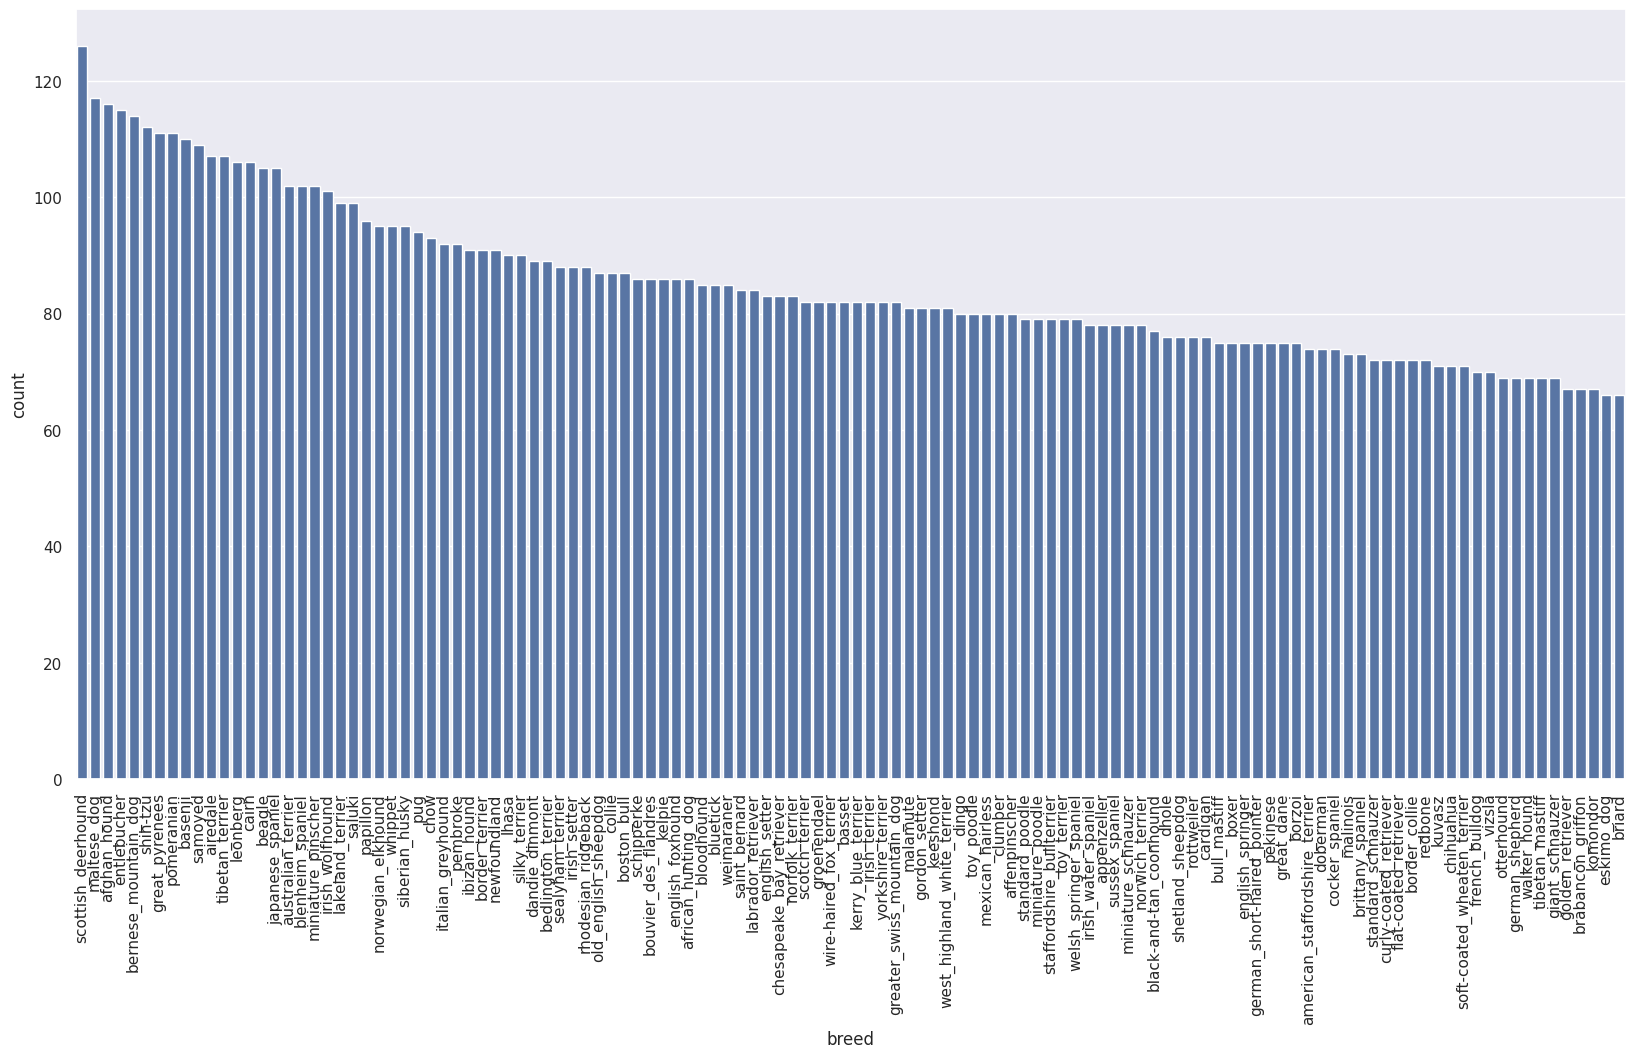

In [ ]:
# lets plot distribution of dog breeds in training data
plot_value_count(labels_df, 'breed')

In [ ]:
# 1.create class folders
parent_folder = "data"
datasets = ["all_data"]
for i in datasets:
  for j in target_labels:
      os.makedirs(parent_folder + "/" + i + "/" + j,  exist_ok=True)

# all data
for _, name, label in labels_df.itertuples():
  original_path = "/content/gdrive/MyDrive/New folder/train1/" + name +".jpg"
  dest_path = "/content/data/all_data/" + label
  shutil.copy(original_path, dest_path)

In [ ]:
all_data_dir = "/content/data/all_data/"

def view_25_random_image(target_dir, target_classes):
  plt.figure(figsize=(18, 12))
  random_images = []
  for i, target_class in enumerate(target_classes):
    # setup the target directory
    target_folder = target_dir + target_class

    # get the random image path
    random_image = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    #print(target_folder + "/" + random_image[0])
    #print(random_image)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"{target_class}")
    plt.axis("off");
    random_images.append(img)
    #print(f"image shape: {img.shape}")
  return random_images

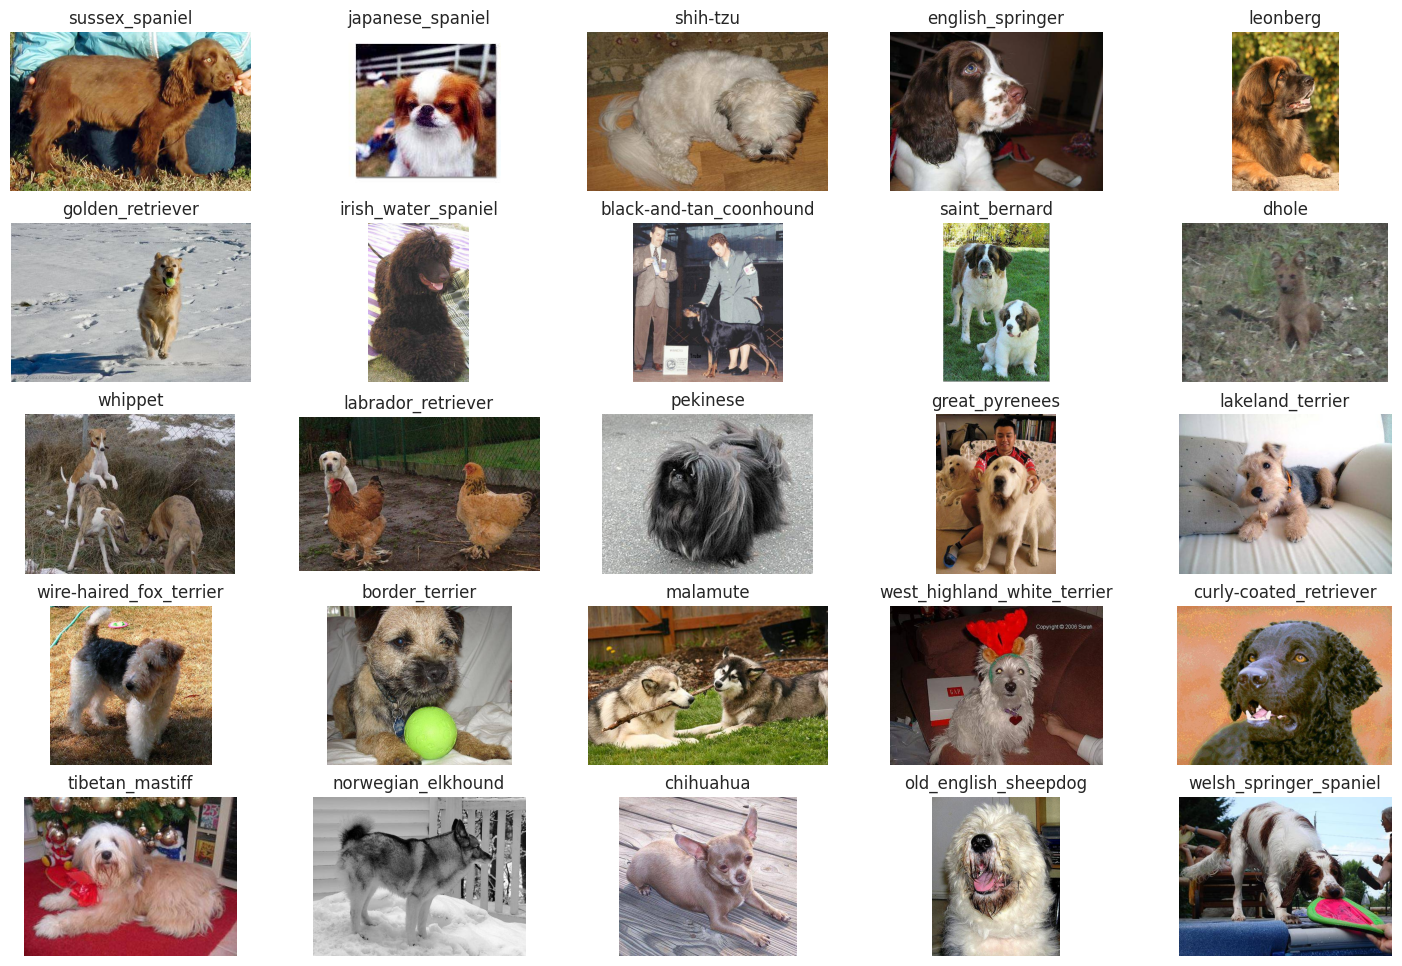

In [ ]:
random_images = view_25_random_image(target_dir=all_data_dir,
                                target_classes = random.sample(target_labels, 25))

In [ ]:
tf.random.set_seed(42)
IMG_SIZE  = (256,256)
IMG_SHAPE = IMG_SIZE +(3,)
BATCH_SIZE = 32
data_all = tf.keras.preprocessing.image_dataset_from_directory(all_data_dir,
                                                              label_mode = "categorical",
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                               )
print(f"all_data batches: {len(data_all)}")

Found 10222 files belonging to 120 classes.
all_data batches: 320


In [ ]:
#data augmentation
data_augmentation_layer = tf.keras.models.Sequential([
                                                preprocessing.RandomFlip("horizontal"),
                                                preprocessing.RandomCrop(height=224, width=224),
                                                preprocessing.RandomRotation(0.2),
                                                preprocessing.RandomZoom(0.1),
                                                preprocessing.RandomContrast(factor=0.1),
                                                ])


# EarlyStopping Callback (stop training in val accuracy not improves)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2,
                                                  restore_best_weights=True)

#ReduceLROnPlateau Callback (Creating learning rate)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-5)

baseline_model = tf.keras.applications.EfficientNetB3(include_top=False)
# trainable freeze
baseline_model.trainable = False
inputs = tf.keras.Input(shape = IMG_SIZE+(3,), name = "input_layer")
#x = data_augmentation_layer(inputs)
x = baseline_model(inputs, training=False) # weights whhich need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pool_layer")(x)
x = layers.Dense(len(data_all.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)
model_0 = tf.keras.Model(inputs, outputs)

train_size = int(0.9* len(data_all))
print(train_size)

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss="categorical_crossentropy",
                              metrics = ["accuracy"])


288


In [ ]:
history_0 = model_0.fit(data_all.take(train_size),
                                      epochs=1,
                                      validation_data = data_all.skip(train_size),
                                      callbacks = [
                                                    early_stopping,
                                                    reduce_lr
                                                  ])

288/288 [==============================] - 2344s 8s/step - loss: 1.3386 - accuracy: 0.7921 - val_loss: 0.4125 - val_accuracy: 0.9036 - lr: 0.0010


In [ ]:
#evaluation
evaluation_0 = model_0.evaluate(data_all.skip(train_size))
print(evaluation_0)

32/32 [==============================] - 231s 7s/step - loss: 0.4111 - accuracy: 0.9016
[0.411065936088562, 0.9015904664993286]


In [ ]:
#save model
model_0.save('/content/gdrive/MyDrive/dog-breed-identification/Dogbreed_model.h5')

In [ ]:
breed_names = data_all.class_names
breed_names = [n.replace('_',' ').capitalize() for n in breed_names]
print(breed_names[0:3])

#save dog breed names
with open('/content/gdrive/MyDrive/dog-breed-identification/class_names', 'wb') as fp:
    pickle.dump(breed_names, fp)

['Affenpinscher', 'Afghan hound', 'African hunting dog']


In [ ]:
#load model
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/dog-breed-identification/Dogbreed_model.h5')

In [2]:
def make_custom_prediction(model, image_path):
  img = Image.open(image_path).resize(IMG_SIZE)
  img = np.array(img, dtype=np.float32)
  img_g = np.expand_dims(img, axis=0)
  custom_predict = loaded_model.predict(img_g)
  plt.figure(figsize=(4,4))
  plt.imshow(img/255)
  plt.title(f"{breed_names[np.argmax(custom_predict[0])]}  ({round(np.max(custom_predict[0]*100))}% confidence)")
  plt.axis(False)
  plt.show()

duche = "/content/gdrive/MyDrive/New folder/custom/00a3edd22dc7859c487a64777fc8d093.jpg"

make_custom_prediction(loaded_model, duche)

NameError: name 'loaded_model' is not defined